Welcome to the mouse model demo!
To begin training our mouse, we will first find and process the proper data. In the following segment, we select the fastest cycle speed found under data, select the time points we chose, and scale it. In the environment script, we select timepoints and scale the data.

/home/andrea/anaconda3/envs/mouse/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


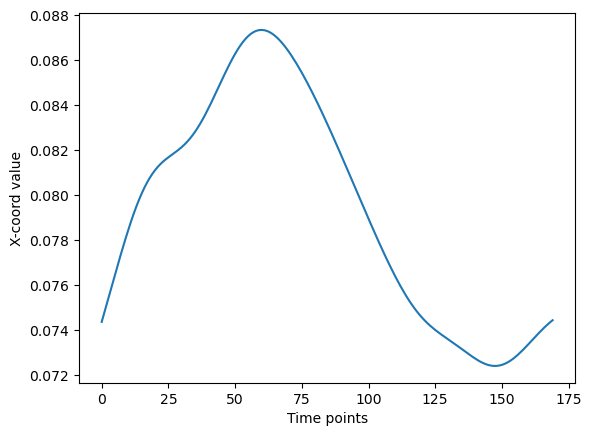

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

mat = scipy.io.loadmat('../data/kinematics_session_mean_alt_fast.mat')
data = np.array(mat['kinematics_session_mean'][2])
data_fast = data[231:401:1] * -1
data_fast_plot = (data_fast/22) + .689

plt.axes(xlabel='Time points', ylabel = 'X-coord value')
plt.plot(data_fast_plot)
plt.show()

Next we will pip install the necessary reops, as per installation guide.

In [3]:
%cd ~/mouse_project
%cd bullet3
%pip install -e .
%cd ../farms_pylog
%pip install -e .
%cd ../farms_container
%pip install -e .
%cd ../farms_muscle
%pip install -e .
%cd ../scripts

/home/andrea/mouse_project
/home/andrea/mouse_project/bullet3
Obtaining file:///home/andrea/mouse_project/bullet3
  Preparing metadata (setup.py) ... done
/home/andrea/anaconda3/envs/mouse/lib/python3.10/site-packages/pip/_internal/metadata/pkg_resources.py:250: UserWarning: Unbuilt egg for RL-Framework-Mujoco-3 [unknown version] (/home/andrea/RL_Distributed_Test/gym-RL_Framework_Mujoco_3)
  self._ws.require(name)
  Running setup.py develop for pybullet
Note: you may need to restart the kernel to use updated packages.
/home/andrea/mouse_project/farms_pylog
Obtaining file:///home/andrea/mouse_project/farms_pylog
  Preparing metadata (setup.py) ... done
  Attempting uninstall: farms-pylog
    Found existing installation: farms-pylog 0.1
    Uninstalling farms-pylog-0.1:
      Successfully uninstalled farms-pylog-0.1
  Running setup.py develop for farms-pylog
/home/andrea/anaconda3/envs/mouse/lib/python3.10/site-packages/pip/_internal/metadata/pkg_resources.py:250: UserWarning: Unbuilt eg

Next, we will begin by defining our parameters. We have an array of indices (called ctrl) that correspond to the joints we are observing:
-RShoulder_rotation - 107
-RShoulder_adduction - 108
-RShoulder_flexion - 109
-RElbow_flexion - 110
-RElbow_supination - 111
-RWrist_adduction - 113
-RWrist_flexion - 114
-RMetacarpus1_flexion - 115, use link (carpus) for pos

In [6]:
import pybullet as p
import time
import argparse
import itertools
import torch
import numpy as np

import farms_pylog as pylog
import model_utils as model_utils
from Mouse_RL_Environment import Mouse_Env
from SAC.replay_memory import PolicyReplayMemory
from SAC.sac import SAC

file_path = "../model_utilities/mouse_fixed.sdf" # mouse model, body fixed except for right arm
pose_file = "../model_utilities/right_forelimb_pose.yaml" # pose file for original pose
muscle_config_file = "../model_utilities/right_forelimb.yaml" # muscle file for right arm

model_offset = (0.0, 0.0, .0475) #z position modified with global scaling

#ARM CONTROL
ctrl = [107, 108, 109, 110, 111, 113, 114]

parser = argparse.ArgumentParser(description='PyTorch Soft Actor-Critic Args')
parser.add_argument('--env-name', default="HalfCheetah-v2",
                    help='Mujoco Gym environment (default: HalfCheetah-v2)')
parser.add_argument('--policy', default="Gaussian",
                    help='Policy Type: Gaussian | Deterministic (default: Gaussian)')
parser.add_argument('--eval', type=bool, default=False,
                    help='Evaluates a policy a policy every 10 episode (default: True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.005, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.005)')
parser.add_argument('--lr', type=float, default=0.001, metavar='G',
                    help='learning rate (default: 0.001)')
parser.add_argument('--alpha', type=float, default=0.2, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy\
                            term against the reward (default: 0.2)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Automaically adjust α (default: False)')
parser.add_argument('--seed', type=int, default=123456, metavar='N',
                    help='random seed (default: 123456)')
parser.add_argument('--policy_batch_size', type=int, default=256, metavar='N',
                    help='batch size (default: 6)')
parser.add_argument('--num_steps', type=int, default=1000001, metavar='N',
                    help='maximum number of steps (default: 1000000)')
parser.add_argument('--hidden_size', type=int, default=256, metavar='N',
                    help='hidden size (default: 1000)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simulator step (default: 1)')
parser.add_argument('--start_steps', type=int, default=0, metavar='N',
                    help='Steps sampling random actions (default: 10000)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--policy_replay_size', type=int, default=4000, metavar='N',
                    help='size of replay buffer (default: 2800)')
parser.add_argument('--cuda', action="store_true",
                    help='run on CUDA (default: False)')
args = parser.parse_args()

###PARAMETERS###
frame_skip = 1
n_frames = 1
timestep = 170
vizualize = True

# Training Loop
total_numsteps = 0
updates = 0
score_history= []
reward_tracker = []
test_history= []
vel_his = []
target_trajectory = []
env_counter_his= []
kinematics_x = []
kinematics_y = []
kinematics_z = []

reward_tracker = []
policy_loss_tracker = []

highest_reward = 0


ModuleNotFoundError: No module named 'pybullet'

Next we will begin the simulation by initializing the environment, agent, and policy memory. We will also begin simulation of a trained model.

In [37]:

mouseEnv = Mouse_Env(file_path, muscle_config_file, pose_file, frame_skip, ctrl, timestep, model_offset, vizualize)
agent = SAC(41, mouseEnv.action_space, args)
policy_memory= torch.load('../models/policy_net_003_-30.pth')

torch.manual_seed(args.seed)
np.random.seed(args.seed)

model_utils.disable_control(mouseEnv.model)
p.setTimeStep(.001)

data_fast = data[231:401:1] * -1
data_fast_cycles = [*data_fast, *data_fast, *data_fast]

mouseEnv.timestep = len(data_fast_cycles)
mouseEnv.x_pos = data_fast_cycles

for i_episode in itertools.count(1):

    episode_reward = 0
    episode_steps = 0
    action_list= []
    done = False

    mouseEnv.reset(pose_file)
    state = mouseEnv.get_cur_state()
    ep_trajectory = []

#num_layers specified in the policy model 
    h_prev = torch.zeros(size=(1, 1, args.hidden_size))
    c_prev = torch.zeros(size=(1, 1, args.hidden_size))

    for i in range(mouseEnv.timestep):

        action, h_current, c_current = agent.select_action(state, h_prev, c_prev)  # Sample action from policy

        action_list.append(action)

        
        next_state, reward, done = mouseEnv.step(action, i_episode)

        episode_reward += reward

        mask = 1 if episode_steps == mouseEnv._max_episode_steps else float(not done)

        if episode_steps == 0:
            ep_trajectory.append((state, action, np.array([reward]), next_state, np.array([mask]), h_prev, c_prev, h_current, c_current))
        else:
            ep_trajectory.append((state, action, np.array([reward]), next_state, np.array([mask])))

        state = next_state
        h_prev = h_current
        c_prev = c_current

        episode_steps += 1
        total_numsteps += 1 

        if done:
            break
    
    if episode_reward > highest_reward:
        highest_reward = episode_reward 

    #pylog.debug("Saving policy and Q network")
    #torch.save(agent.policy.state_dict(), '../models/policy_net.pth')
    #torch.save(agent.critic.state_dict(), '../models/value_net.pth')

    pylog.debug('reward at total timestep {}: {}'.format(mouseEnv.timestep, episode_reward))
    pylog.debug('highest reward so far: {}'.format(highest_reward))
    reward_tracker.append(episode_reward)
    
    policy_memory.push(ep_trajectory)
        
mouseEnv.close() #disconnects server


NameError: name 'Mouse_Env' is not defined